# Potential energy landscape of an atomic cluster

In this notebook we show how to use TopSearch to map the potential energy landscape of a small atomic cluster. Exploring potential energy surfaces is a key task in chemical physics, because all physical properties of a system are encoded in its potential energy surface. One method for extracting these properties is to use the energy landscape framework (https://doi.org/10.1146/annurev-physchem-050317-021219). In this framework we encode the potential energy surface through its stationary points (points at which the gradient goes to zero). The stationary points are separated into local minima (any displacement increases the energy) and transition states (these points are maximal in one direction and minimal in all the remaining). Transition states can be diagnosed by a single negative eigenvalue of the second derivative matrix. The set of minima and transition states are stored in a kinetic transition network (https://doi.org/10.1016/j.sbi.2008.01.008). From the minima we can compute the thermodynamics of a physical system, and we can also compute the kinetics given the transition states too. Therefore, by locating all the stationary points we can determine the relevant properties of a physical system. In this example, we compute the kinetic transition network for a small atomic cluster. We show the kinetic transition network for a very simple surface below.

![alt text](StationaryPointsExample.png "Title")

Local minima and transition states are shown by green and red circles, respectively. The downhill direction at each transition state is shown with pink arrows, and the two minima connected to each transition state are joined with solid black lines.

## Initialise classes

Before we run any calculations we require several classes to be instantiated. We list each of them in turn here, and describe their functionality. First, we specify the coordinates class, which stores and operates on the cluster configuration. We specify the atomic species of each atom and an initial position, along with the length at which two atoms are not considered bonded.

In [1]:
import numpy as np
from topsearch.data.coordinates import AtomicCoordinates
atom_labels = ['C','C','C','C','C','C','C']
position = np.array([[0.0, 0.0, 0.0],
                     [3.0, 0.0, 0.0],
                     [3.0, 3.0, 0.0],
                     [0.0, 3.0, 0.0],
                     [0.0, 0.0, 3.0],
                     [0.0, 3.0, 3.0],
                     [3.0, 3.0, 3.0]])
coords = AtomicCoordinates(atom_labels=atom_labels, # specify the atomic labels
                           position=position.flatten(), # provide the initial position of all atoms
                           bond_cutoff=1.5) # specify the distance over which two atoms are not considered bonding

We require a potential class that specifies the potential energy function for the atomic system. The class provides the functionality to compute the potential energy and its first and second derivatives when given a set of coordinates. In this example we use the Lennard Jones potential, which is a computationally-efficient interatomic potential used to explore idealised atomic clusters.

In [2]:
from topsearch.potentials.atomic import LennardJones
lj = LennardJones()

Next we initialise the comparison class, which is responsible for aligning atomic configurations and determining the distance between them. We would like to retain only one copy of each minimum and transition state and this class achieves that. Comparing atomic structures requires consideration of translation and rotation of the whole cluster, along with permutation of the atoms. Overall translation and rotation of an atomic configuration do not change its energy or structure and, therefore, structures related by overall rotation or translation should be recognised as the same. Furthermore, permutation of indistinguishable atoms also results in no change in energy and permutation should also be accounted for when comparing structures. The MolecularSimilarity class takes care of these technical considerations and accounts for translational, rotational and permutational symmetry. Therefore, we can distinguish repeated structures and filter them out, leaving only unique stationary points.

In [18]:
from topsearch.similarity.molecular_similarity import MolecularSimilarity
comparer = MolecularSimilarity(distance_criterion=0.2, # distance between which two configurations are considered the same
                               energy_criterion=1e-1, # energy beneath which two configurations are considered the same
                               weighted=False, # weight each atom proportionally by its atomic mass 
                               allow_inversion=True) # group together configurations related by the inversion operation

We initialise the KineticTransitionNetwork object. This object contains the networkx graph in which all the minima and transition states are stored. Minima are nodes in this graph and transition states are encoded as the edges between nodes. This class controls all access to the network and performs operations to extract information and analyse it.

In [4]:
from topsearch.data.kinetic_transition_network import KineticTransitionNetwork
ktn = KineticTransitionNetwork()

Locating transition states requires a combination of single-ended and double-ended searches.

- Double-ended searches: take two minima as input and attempt to find the lowest-valued path between them. 
- Single-ended searches: start from a single point and follow the eigenvector corresponding to the most negative eigenvalue until they converge to a transition state.

These two searches are used in tandem, with an initial double-ended search, following by a single-ended search applied to each local maximum on the path.

The double-ended search algorithm we use here is the nudged elastic band (https://doi.org/10.1142/9789812839664_0016) The algorithm places a chain of intermediate configurations evenly spaced between the specified endpoint minima. These configurations are linked by an artifical harmonic potential to prevent them separating and then these chain of structures are minimised on the potential energy surface. These chain of states function a lot like an elastic band, deforming so as to minimise the energy of the pathway between two minima, resulting in an approximation to the lowest energy pathway.

In [5]:
from topsearch.transition_states.nudged_elastic_band import NudgedElasticBand
neb = NudgedElasticBand(potential=lj, # the function determining the potential energy
                        force_constant=50.0, # force of the harmonic potential holding configurations together
                        image_density=10.0, # the number of intermediate configurations (per unit distance)
                        max_images=20, # the upper limit to the number of intermediate configurations
                        neb_conv_crit=1e-2) # the gradient at which the elastic band is converged

The single-ended search method we use is hybrid eigenvector-following (https://doi.org/10.1103/PhysRevB.59.3969). This class provides methods to take a single point and converge it to the nearest transition state. It works by iteratively finding the steepest uphill direction, following that direction, and then minimising in the orthogonal directions. The process is repeated until the gradient reduces to a sufficiently small value to be converged to a stationary point. Such a stationary point is a maximum in one direction and a minimum in all others. The transition state is connected to two minima, which we find by minimising after pushing off along the direction in which it is maximal.

In [6]:
from topsearch.transition_states.hybrid_eigenvector_following import HybridEigenvectorFollowing
hef = HybridEigenvectorFollowing(potential=lj, # function providing the potential energy
                                 ts_conv_crit=1e-4, # gradient below which the transition state is converged
                                 ts_steps=150, # maximum number of steps before giving up
                                 pushoff=1e-1, # the size of the displacement before starting local minimisation
                                 max_uphill_step_size=0.3, # the biggest allowed step along a direction
                                 positive_eigenvalue_step=0.3) # the size of step when the direction isn't uphill

For global optimisation algorithms we need to be able to propose new structures from the existing ones. The efficiency of global optimisation relies on the proposal of good candidate positions. For molecular systems this is an involved problem with a lot of research invested into it. For atomic clusters without a bonding framework to preserve we apply random perturbations to randomly-selected atoms. This class manages the perturbations to propose new states, it is given the max_displacement, and the most atoms that can be moved at once.

In [7]:
from topsearch.global_optimisation.perturbations import AtomicPerturbation
step_taking = AtomicPerturbation(max_displacement=0.5, # maximum displacement in the units of the coordinates
                                 max_atoms=3) # maximum number of atoms that can be moved simultaneously

Initialise the global optimisation class. The global optimisation algorithm is basin-hopping, which is provided with the step-taking class previously created. Basin-hopping steps around the potential energy surface performing local minimisations and subsequently accepting or rejecting the new local minima based on a Metropolis-like criterion on the energy.

In [8]:
from topsearch.global_optimisation.basin_hopping import BasinHopping
optimiser = BasinHopping(ktn=ktn, # network to store the found minima
                         potential=lj, # the potential energy function we are optimising on
                         similarity=comparer, # object to test if minima are the same are not
                         step_taking=step_taking) # object to propose new configurations

Finally, we feed many of these objects into a NetworkSampling object that controls all the landscape generation. This object allows for simple calls to be made that perform the combination of algorithms for landscape generation. We pass it the global_optimiser and the transition state location methods. Transition state location searches are embarrassingly parallel so it is possible to parallelise this process by uncommenting the final two lines, but in this example it is unnecessary.

In [9]:
from topsearch.sampling.exploration import NetworkSampling
explorer = NetworkSampling(ktn=ktn,
                           coords=coords,
                           global_optimiser=optimiser,
                           single_ended_search=hef,
                           double_ended_search=neb,
                           similarity=comparer)#,
                           #multiprocessing_on=True,
                           #n_processes=4)

## 1. Global optimisation

First, we will locate local minima of the six-atom atomic cluster within the Lennard-Jones potential. Each local minimum is a stable atomic configuration (i.e. any displacement from this point will produce an increase in energy), and therefore, the set of minima are key in computing the thermodynamics of a system. We will use the basin-hopping algorithm (https://doi.org/10.1021/jp970984n) to locate all minima, as specified in the optimiser class. Basin-hopping is an efficient global optimisation algorithm, and we store all local minima that are located during the search. Global optimisation can be invoked using

In [10]:
explorer.get_minima(coords=coords, # the 
                    n_steps=150, # the number of basin-hopping steps
                    conv_crit=1e-5, # the convergence criterion for local minimisation
                    temperature=1.0, # sampling parameter that controls acceptance of new minima
                    test_valid=True) # check the eigenspectrum to guarantee local minimum

/Users/lukedicks/topography-searcher/src/topsearch/potentials/atomic.py:37: RuntimeWarning: divide by zero encountered in scalar divide
  r6_term = self.sigma/(dist**3)
/Users/lukedicks/topography-searcher/src/topsearch/potentials/atomic.py:82: RuntimeWarning: invalid value encountered in scalar subtract
  (r6_term - 2.0 * (r6_term**2))) / dist


We have now computed all local minima of the potential energy surface, which are stored in the ktn object. We validate that there are four distinct atomic configurations in this network and extract the coordinates of each minimum from it. We write the coordinates to file in the standard xyz format to store these configurations for later analysis.

In [11]:
for i in range(ktn.n_minima):
    coords.position = ktn.get_minimum_coords(i)
    coords.write_xyz('%i' %i)
print(f"Potential energy surface contains {ktn.n_minima} minima")

Potential energy surface contains 4 minima


We can visualise these minima within the notebook by reading the xyz files back in. We show one as an example here, but the others can be visualised by changing the number when opening the file.

In [12]:
import py3Dmol
xyzview = py3Dmol.view(width=400, height=400)
with open('coords1.xyz') as xyz_file:
    minimum = "".join([x for x in xyz_file])
xyzview.addModel(minimum)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Here, the atomic configurations are displayed as a polygon. Each atom is a node of the polygon and lines connect those atoms that are close enough to be considered linked by a bond. For atomic clusters such polygons allow the atomic structure to be more easily identified.

## 2. Find transition states

Having successfully located the local minima we will aim to locate the transition states between them. These transition states are the maxima on the minimum energy paths between minima, and for potential energy surfaces these give the lowest energy barrier between two local minima. From the transition states we can estimate the evolution of a physical system over time (paper). We find transition states by selecting pairs of local minima and using the double and single-ended transition state searches between them. These searches work better when the local minima are adjacent on the potential energy surface and we use the 'ClosestEnumeration' scheme to select pairs of minima that are close in space. We attempt to find transition states between each minimum and its `cycles` nearest neighbours in the network.

In [13]:
explorer.get_transition_states(method='ClosestEnumeration', # try and find transition states between each minimum and its closest neighbours
                               cycles=4) # take the four nearest neighbours

There are only four minima so finding the transition states doesn't take long. We should have located three transition states, which ensures that all four minima are connected. Again we can extract the coordinate information from the network that now contains both minima and transition states to write the transition state configurations to file. The transition states are edges in the network graph, and we extract their properties by referencing the two minima that they connect.

In [14]:
print(f'Network contains {ktn.n_ts} transition states')
for u, v in ktn.G.edges:
    coords.position = ktn.get_ts_coords(u, v)
    coords.write_xyz('%i_%i' %(u, v))
    print("Transition state connecting ", u, v, ktn.G.get_edge_data(u, v))

Network contains 3 transition states
Transition state connecting  0 1 {'coords': array([-0.0672573 , -0.74344166, -0.0791589 ,  0.40492598, -0.18529593,
       -0.94041498,  0.83017721, -0.10908997,  0.0785695 , -0.38495569,
        0.29390767, -0.33514594, -1.03166272, -0.33962382,  0.31804511,
       -0.06639099,  0.06824519,  0.70895569,  0.40609733,  0.91216398,
        0.12517355]), 'energy': -15.319864440860625}
Transition state connecting  1 2 {'coords': array([ 0.07462605, -0.56836227, -0.06663733, -0.50063044, -0.38937053,
       -1.00771164,  0.9039203 ,  0.12262168,  0.19084642,  0.13066202,
        0.42372204, -0.57248751, -0.81641395,  0.08846261, -0.04485482,
        0.23835414, -0.3151908 ,  0.99662291, -0.03051812,  0.63811727,
        0.50422197]), 'energy': -15.283421275350364}
Transition state connecting  1 3 {'coords': array([ 1.26182328e-01, -8.03139677e-01, -5.80459468e-02, -3.76101837e-01,
       -3.89032461e-01, -9.59350692e-01,  7.63577833e-01,  7.86935870e-02,

We can write this network to file to store for later analysis. The network is stored within five files: min.data, min.coords, ts.data, ts.coords and pairlist.txt. The format of each is a text file containing  follows, where each line in min/ts.data corresponds to the same line in min/ts.coords

- min.data:   index potential_energy
- min.coords: atomic_coordinates
- ts.data:    connected_min1 connected_min2 potential_energy
- ts.coords:  atomic_coordinates
- pairlist:   the pairs of minima we have attempted transition states between

In [15]:
ktn.dump_network()

Again, we can visualise the structures of the transition states as polygons. We visualise just the first here, but the other can be seen by changing the ts_index parameter.

In [16]:
import py3Dmol
transition_states = []
# Get all the transition state connections
for u, v in ktn.G.edges():
    transition_states.append([u, v])
xyzview = py3Dmol.view(width=400, height=400)
# Specify the transition state we want
ts_index = 0
# Find its two connected minima
minimum1 = transition_states[ts_index][0]
minimum2 = transition_states[ts_index][1]
# Read the corresponding xyz file we wrote earlier
with open('coords%i_%i.xyz' %(minimum1, minimum2)) as xyz_file:
    ts = "".join([x for x in xyz_file])
xyzview.addModel(ts)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

We cannot directly visualise the potential energy surface in this example, as the surface has (3*6)+1 dimensions. We have visualised the coordinates for each of the stationary points (the minima and the transition states), but we can further probe the structure of the potential energy surface using disconnectivity graphs (https://doi.org/10.1038/29487). Disconnectivity graphs can be used for surfaces of any dimensionality. They display the minima and the barriers (via transition states) needed to move between them, which are the relevant quantities for understanding the overall kinetic behaviour of a system. Each vertical line is a local minimum which ends at its corresponding energy. The lines merge at the energy at which the two minima become intercovertible, which is the energy of the maximum transition state on a path between them. Here we see the four minima, and the transition between the two lowest minima occurs at an energy of around -15.50.

In [ ]:
# Ensure that LaTeX fonts and equations can be used for plotting
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

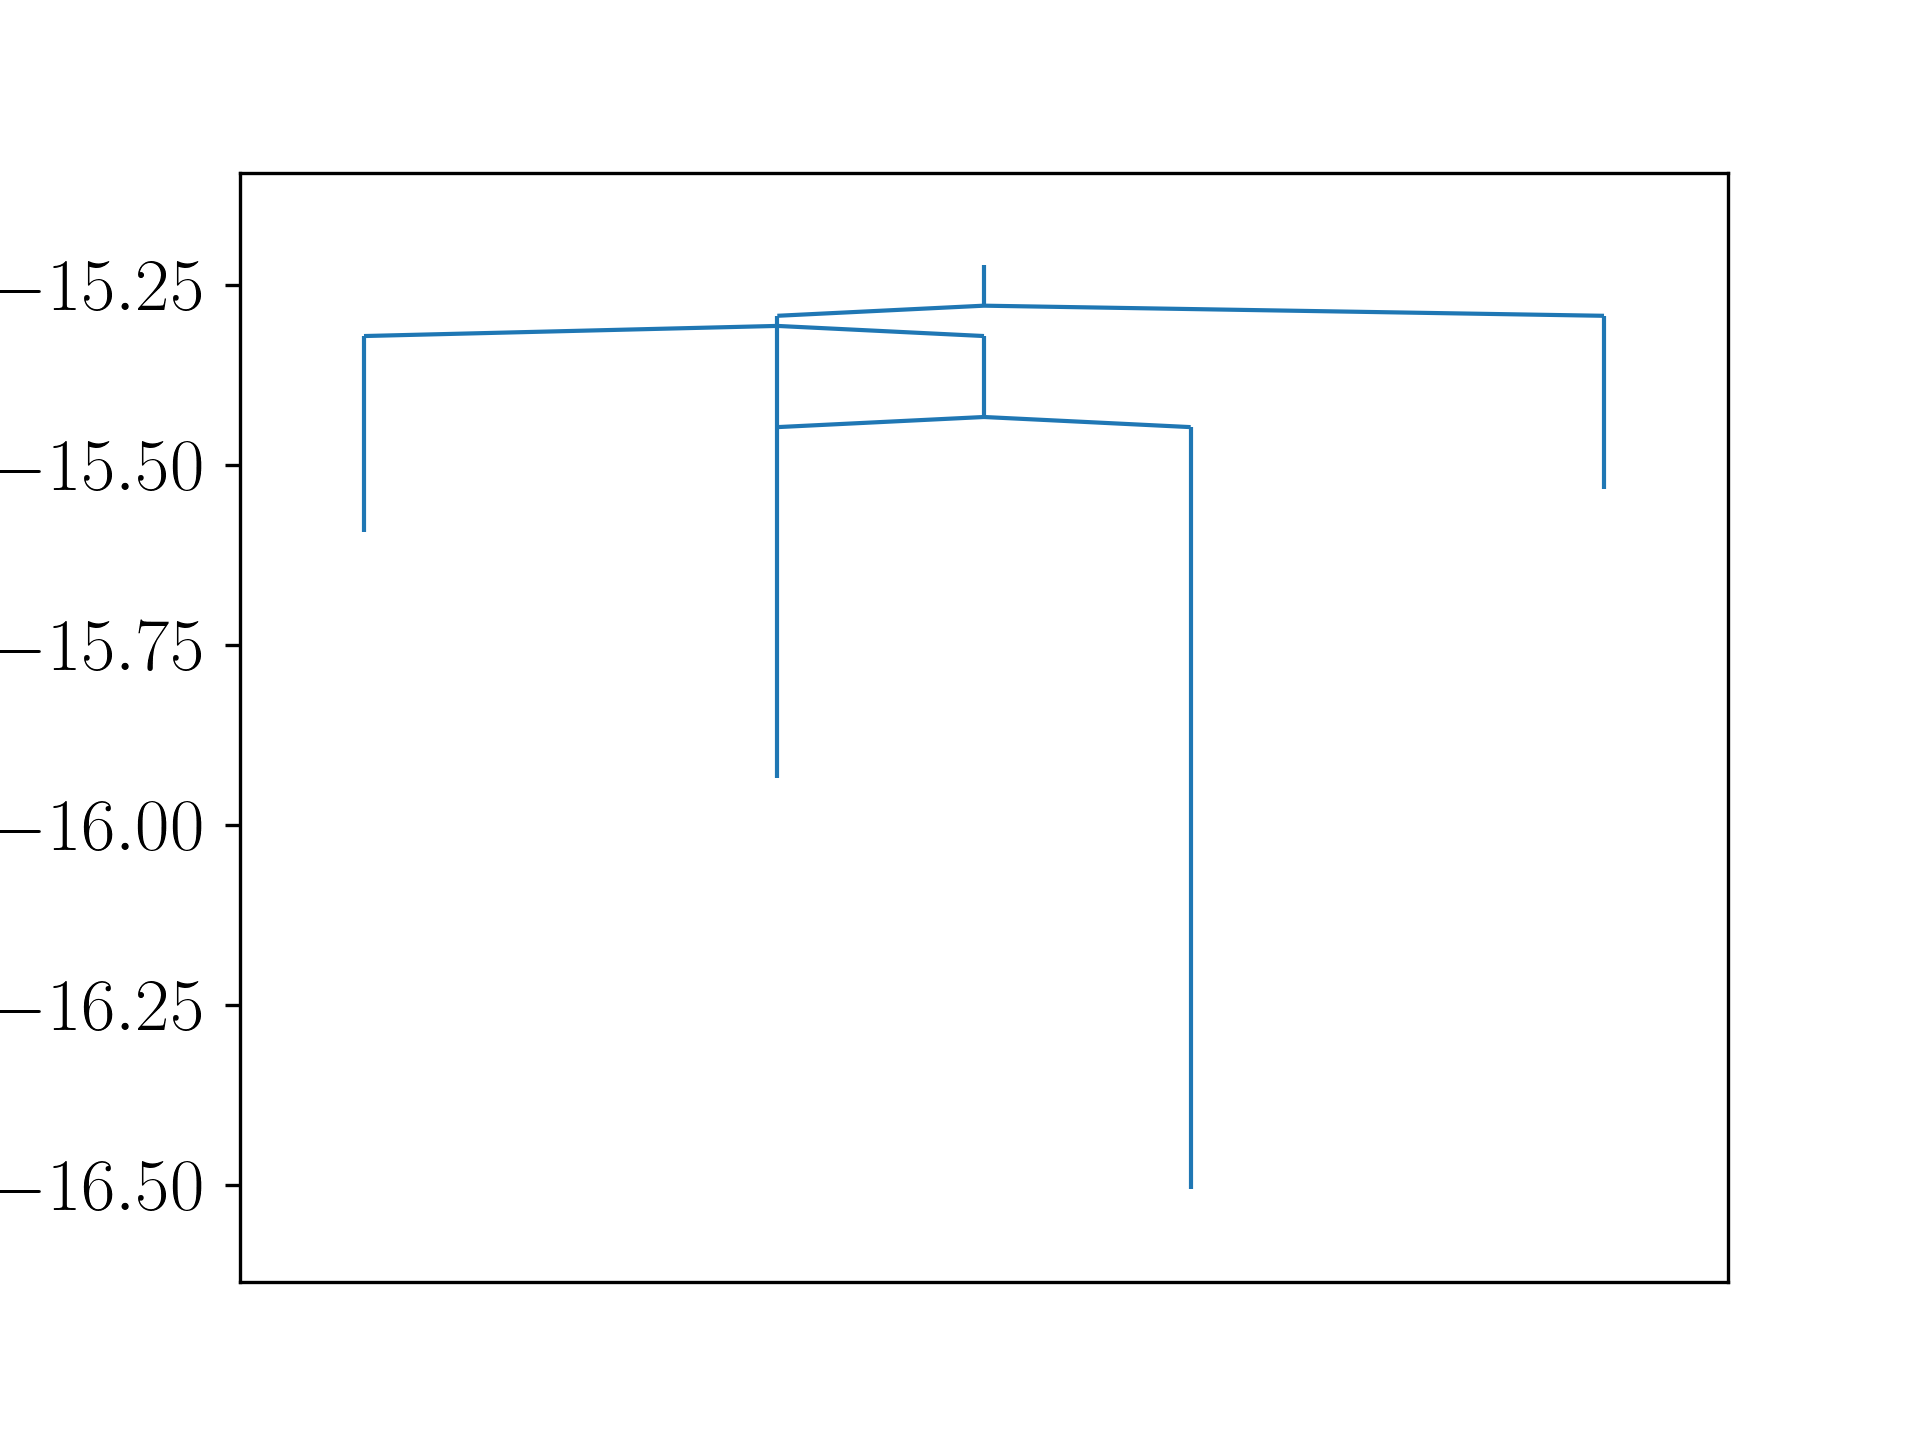

In [17]:
from IPython.display import Image
from topsearch.plotting.disconnectivity import plot_disconnectivity_graph
plot_disconnectivity_graph(ktn=ktn,
                           levels=100)
Image(filename='DisconnectivityGraph.png')